In [36]:
# Bibliotecas para EDA
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Bibliotecas para Machine Learning
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Otimização de parâmetros
import optuna

# EDA

In [2]:
# Carregar dataset
df = pd.read_csv('datasets/segmento_clientes.csv')

In [3]:
# Visualizar os dados
df.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [4]:
# Estrutura dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [5]:
# Valores possíveis das variáveis categóricas

df['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [6]:
df['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [7]:
df['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [8]:
# Conferir inovacao, que poderia ser categórica, por ser ordinal
df['inovacao'].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [9]:
# Verificar a distribuição dos valores da variável target: segmento_de_cliente
contagem_target = df.value_counts('segmento_de_cliente')
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

- Temos uma base desbalanceada, com uma concentração de clientes muito alta em Silver e Bronze

In [10]:
# Criar lista ordenada do target
lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

# Plotar a distribuição do target
px.bar(contagem_target, color=contagem_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [11]:
# Plotar a distribuição do target - percentual
percentual_target = contagem_target / len(df) * 100
percentual_target

segmento_de_cliente
Silver     52.0
Bronze     40.4
Starter     4.4
Gold        3.2
Name: count, dtype: float64

In [12]:
# Plotar a distribuição do target
px.bar(percentual_target, color=percentual_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

- Mais de 92% da base estão em Bronze e Silver

In [13]:
# Plotar a distribuição da Localização
percentual_localizacao = df.value_counts('localizacao') / len(df) * 100
px.bar(percentual_localizacao, color=percentual_localizacao.index)

In [14]:
# Plotar a distribuição da Atividade Econômica
percentual_atividade_economica = df.value_counts('atividade_economica') / len(df) * 100
px.bar(percentual_atividade_economica, color=percentual_atividade_economica.index)

In [15]:
# Plotar a distribuição da Inovação
percentual_inovacao = df.value_counts('inovacao') / len(df) * 100
px.bar(percentual_inovacao, color=percentual_inovacao.index)

- Apesar do desbalanceamento com o segmento de clientes, não temos o mesmo problema nas demais variáveis categóricas

In [16]:
# Criar uma tabela de contingência (crosstab) para buscar uma correlação entre Localização e Target
crosstab_localizacao = pd.crosstab(df['localizacao'], df['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
table_localizacao = ff.create_table(crosstab_localizacao)
table_localizacao.show()

In [17]:
# Criar uma tabela de contingência (crosstab) para buscar uma correlação entre Localização e Target
crosstab_atividade = pd.crosstab(df['atividade_economica'], df['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
table_atividade = ff.create_table(crosstab_atividade)
table_atividade.show()

- Apesar de desbalanceada a base, podemos ver que os dados não apresentam correlação entre Target e Localização ou Atividade Econômica.

In [18]:
# Criar uma tabela de contingência (crosstab) para buscar uma correlação entre Localização e Target
crosstab_inovacao = pd.crosstab(df['inovacao'], df['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
table_inovacao = ff.create_table(crosstab_inovacao)
table_inovacao.show()

- Já no caso de Inovação, temos uma relação clara que ela influencia a classificação do segmento empresa.

In [19]:
# Distribuição Idade da empresa
px.histogram(df, x='idade')

In [20]:
# Distribuição Idade da empresa
px.histogram(df, x='faturamento_mensal')

- Graficamente falando, a Idade e Faturamento Mensal mostram uma distribuição normal 

In [21]:
# Verificar se as variáveis numéricas possuem correlação com o target
px.box(df, x='segmento_de_cliente', y='idade', color='segmento_de_cliente', category_orders={'segmento_de_cliente':lista_segmentos})

In [22]:
# Verificar se as variáveis numéricas possuem correlação com o target
px.box(df, x='segmento_de_cliente', y='faturamento_mensal', color='segmento_de_cliente', category_orders={'segmento_de_cliente':lista_segmentos})

- A idade parece estar relacionadas com o nosso target, mas não parece ser muito expressivo
- No caso do faturamento com menos força, quase inexistente

In [23]:
# Agora vamos avaliar a correlação com testes estatísticos

# Teste de Qui-Quadrador de Pearson
# H0: As variáveis são independentes    (p-valor > 0.05)
# H1: As variáveis não são independentes (temos correlação) (p-valor < 0.05)

valor_esperado, valor_observado, stats = pg.chi2_independence(df, 'segmento_de_cliente', 'localizacao')

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.



In [24]:
# Valor esperado: é a frequência que seria esperada se não houvesse a associação entre as variáveis
# É calculado usando a distribuição assumida do teste do qui-quadrado
valor_esperado

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,44.844,52.924,48.884,55.348
Gold,3.552,4.192,3.872,4.384
Silver,57.720,68.120,62.920,71.240
Starter,4.884,5.764,5.324,6.028


In [25]:
# Valor observado: é a frequência real dos dados coletados
valor_observado

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,39,62,45,56
Gold,4,3,5,4
Silver,63,60,65,72
Starter,5,6,6,5


In [26]:
# Estatísticas
stats.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,5.19335,9.0,0.81714,0.05884,0.11369
1,cressie-read,0.66667,5.19198,9.0,0.81726,0.05883,0.11367
2,log-likelihood,0.00000,5.19713,9.0,0.81680,0.05886,0.11374
3,freeman-tukey,-0.50000,5.20798,9.0,0.81581,0.05892,0.11390
4,mod-log-likelihood,-1.00000,5.22494,9.0,0.81428,0.05902,0.11414
5,neyman,-2.00000,5.27777,9.0,0.80945,0.05932,0.11490


In [27]:
valor_esperado, valor_observado, stats = pg.chi2_independence(df, 'segmento_de_cliente', 'localizacao')
stats.round(5)

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.



,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,5.19335,9.0,0.81714,0.05884,0.11369
1,cressie-read,0.66667,5.19198,9.0,0.81726,0.05883,0.11367
2,log-likelihood,0.00000,5.19713,9.0,0.81680,0.05886,0.11374
3,freeman-tukey,-0.50000,5.20798,9.0,0.81581,0.05892,0.11390
4,mod-log-likelihood,-1.00000,5.22494,9.0,0.81428,0.05902,0.11414
5,neyman,-2.00000,5.27777,9.0,0.80945,0.05932,0.11490


In [28]:
valor_esperado, valor_observado, stats = pg.chi2_independence(df, 'segmento_de_cliente', 'inovacao')
stats.round(5)

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7661: RuntimeWarning:

divide by zero encountered in power

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7661: RuntimeWarning:

invalid value encountered in multiply

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7658: RuntimeWarning:

divide by zero encountered in divide



,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,164.29399,27.0,0.0,0.33095,0.99850
1,cressie-read,0.66667,165.49946,27.0,0.0,0.33216,0.99861
2,log-likelihood,0.00000,181.48878,27.0,0.0,0.34784,0.99951
3,freeman-tukey,-0.50000,NaN,27.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,27.0,0.0,inf,NaN
5,neyman,-2.00000,NaN,27.0,NaN,NaN,NaN


- Temos o p-value > 0.05 para Localização e Atividade Econômica, com o Segmento de cliente, demonstrando que são variáveis independentes.
- Temos o p-value < 0.05 para Inovação com Segmento de cliente, demonstrando que são variáveis dependentes.

# Treinamento do modelo

In [29]:
# Separar variáveis independentes (X) e nosso target (y)
X = df.drop(columns=['segmento_de_cliente'])
y = df['segmento_de_cliente']

In [30]:
# Criar o Pipeline de treinamento
# 1. Converter variáveis categóricas em números - OneHotEncoder
# 2. Fazer o treinamento do modelo

# Listar as variáveis categóricas
categorical_features = ['atividade_economica', 'localizacao']

# Criar um transformer que converte variáveis categóricas em números
categorical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')), # PReenche com a moda para missing values
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('cat', categorical_transformer, categorical_features)
  ]
)

# Pipeline com o preprocessor e o modelo de árvore de decisão
model = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('classifier', DecisionTreeClassifier())
])


In [38]:
# Treinar o modelo com a validação cruzada, usando o StratifiedKFold, dado que as classes estão desbalanceadas
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)


## Métricas

In [39]:
# Mostrar o retorno do cross-validation
metrics = cross_validate(model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)
metrics

{'fit_time': array([0.02454638, 0.0215683 , 0.01754594]),
 'score_time': array([0.01216292, 0.01080561, 0.01010013]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
        

In [33]:
# Média da acurácia, considerando os 3 splits
metrics['test_accuracy'].mean()

np.float64(0.4739917754851743)

In [ ]:
# Acurácia
# - Total de previsões corretas / total de previsões do modelo
# - Em nosso caso, tivemos um acerto de 47.39%
# Ou seja, nosso modelo não está muito bom

In [34]:
# Fazer predições com o nosso modelo usando Cross Validation
y_pred = cross_val_predict(model, X, y, cv=cv_folds)

In [37]:
# Avaliar o desempenho do modelo
classification_report_str = classification_report(y, y_pred)
print(f'Relatório de Classificação:\n{classification_report_str}')

Relatório de Classificação:
              precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/rcmonteiro/.local/share/virtualenvs/arvore_decisao-0wsntbgV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



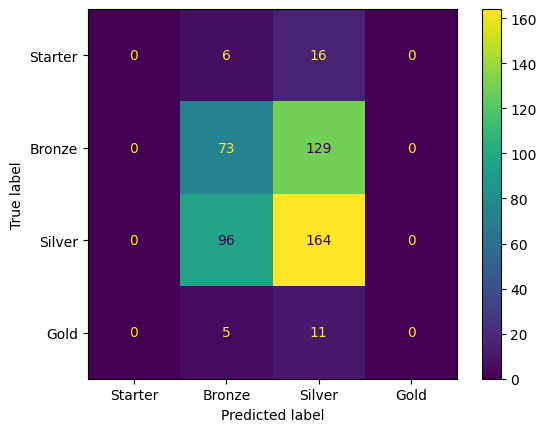

In [40]:
# Mostrar Matriz de Confusão
confusion_matrix = confusion_matrix(y, y_pred, labels=lista_segmentos)
display = ConfusionMatrixDisplay(confusion_matrix, display_labels=lista_segmentos)
display.plot()